# Compare: LinearReg, PCA+LinearReg, LDA+LinearReg, DCT+LinearReg
#“We are trying to predict the critical temperature of superconductors using different feature transformation + regression techniques, and compare their performance.”

This notebook runs four pipelines on the superconductivity dataset (target = `critical_temp`):
1. Ridge on full features
2. PCA → Ridge
3. LDA (quantile bins) → Ridge
4. DCT (keep first-k) → Ridge

It reports train/test RMSE, MAE, R² and saves a CSV with the metrics.


“Here we import all the required libraries for machine learning, feature transformation, and model evaluation.”



In [1]:

# Imports and global settings
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fftpack import dct
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error

# Notebook settings
RANDOM_STATE = 42
TEST_SIZE = 0.20

# Method-specific params
# PCA_K = 50
# LDA_BINS = 50
# DCT_K = 50
FEAT_LIST = [70, 60, 50, 40]
# FEAT_LIST = [i for i in range(75, 25, -5)]

# Groups and Features
groups = ["Reg", "PCA + Reg", "LDA + Reg", "DCT + Reg"]
features = ["80", "70", "60", "50", "40"]

# Files / paths
# CSV_REL = os.path.join("data", "superconductivty_data_set.csv")
CSV_REL = "superconductivty_dataset.csv"
OUT_DIR = "data"
METRICS_CSV = os.path.join(OUT_DIR, "metrics_comparison.csv")

# Utility
def rmse(y_true, y_pred):
    return root_mean_squared_error(y_true, y_pred)


In [2]:
# Load CSV (adjust path if needed)
csv_path = os.path.join(os.getcwd(), CSV_REL)
if not os.path.exists(csv_path):
    raise FileNotFoundError(f"CSV not found at {csv_path}. Place 'superconductivty_data_set.csv' in data/")

df = pd.read_csv(csv_path)
# strip whitespace from column names
df.rename(columns={c: c.strip() for c in df.columns}, inplace=True)

TARGET = "critical_temp"
if TARGET not in df.columns:
    raise KeyError(f"Target '{TARGET}' not found. Columns: {list(df.columns)[:20]}")

print("Loaded dataset:", df.shape)
df.head()


Loaded dataset: (21263, 82)


,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,...,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,4,88.944468,57.862692,66.361592,36.116612,1.181795,1.062396,122.90607,31.794921,51.968828,...,2.257143,2.213364,2.219783,1.368922,1.066221,1,1.085714,0.433013,0.437059,29.0
1,5,92.729214,58.518416,73.132787,36.396602,1.449309,1.057755,122.90607,36.161939,47.094633,...,2.257143,1.888175,2.210679,1.557113,1.047221,2,1.128571,0.632456,0.468606,26.0
2,4,88.944468,57.885242,66.361592,36.122509,1.181795,0.975980,122.90607,35.741099,51.968828,...,2.271429,2.213364,2.232679,1.368922,1.029175,1,1.114286,0.433013,0.444697,19.0
3,4,88.944468,57.873967,66.361592,36.119560,1.181795,1.022291,122.90607,33.768010,51.968828,...,2.264286,2.213364,2.226222,1.368922,1.048834,1,1.100000,0.433013,0.440952,22.0
4,4,88.944468,57.840143,66.361592,36.110716,1.181795,1.129224,122.90607,27.848743,51.968828,...,2.242857,2.213364,2.206963,1.368922,1.096052,1,1.057143,0.433013,0.428809,23.0


In [3]:
# Split first to avoid leakage (we'll fit preprocessors on training data only)
X_df = df.drop(columns=[TARGET]).copy()
y = df[TARGET].values

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)
print("Train / Test sizes:", X_train_df.shape[0], X_test_df.shape[0])
print("Target stats (train):", pd.Series(y_train).describe().to_dict())


Train / Test sizes: 17010 4253
Target stats (train): {'count': 17010.0, 'mean': 34.53330097442681, 'std': 34.33467260601755, 'min': 0.00021, '25%': 5.4, '50%': 20.0, '75%': 63.0, 'max': 185.0}


In [4]:
# Fit imputer + scaler on training set
imputer = SimpleImputer(strategy="mean")
scaler = StandardScaler()

X_train_imp = imputer.fit_transform(X_train_df)
X_train_scaled = scaler.fit_transform(X_train_imp)

X_test_imp = imputer.transform(X_test_df)
X_test_scaled = scaler.transform(X_test_imp)

print("Scaled feature shape (train):", X_train_scaled.shape)


Scaled feature shape (train): (17010, 81)


In [5]:
def train_and_eval_ridge(X_tr, X_te, y_tr, y_te):
    t0 = time.perf_counter()
    model = Ridge(alpha=1.0, random_state=RANDOM_STATE)
    model.fit(X_tr, y_tr)
    t_train = time.perf_counter() - t0

    pred_tr = model.predict(X_tr)
    pred_te = model.predict(X_te)

    return {
        "train_time_sec": t_train,
        # "train_rmse": float(rmse(y_tr, pred_tr)),
        "test_rmse": float(rmse(y_te, pred_te)),
        # "train_mae": float(mean_absolute_error(y_tr, pred_tr)),
        "test_mae": float(mean_absolute_error(y_te, pred_te)),
        # "train_r2": float(r2_score(y_tr, pred_tr)),
        "test_r2": float(r2_score(y_te, pred_te))
    }


1) Ridge on full features

In [6]:
print("Running: Ridge on FULL features")
res_full = train_and_eval_ridge(X_train_scaled, X_test_scaled, y_train, y_test)
res_full.update({"method": "ridge_full", "notes": "no_reduction", "reduced_shape": X_train_scaled.shape})
res_full

Running: Ridge on FULL features


{'train_time_sec': 0.0744293000025209,
 'test_rmse': 17.404416816403057,
 'test_mae': 13.218694681219267,
 'test_r2': 0.7368440027930256,
 'method': 'ridge_full',
 'notes': 'no_reduction',
 'reduced_shape': (17010, 81)}

2) PCA → Ridge

In [7]:
PCA_K = FEAT_LIST
res_pca = []

for pca_k in PCA_K:
    print(f"Running: PCA[{pca_k}] -> Ridge")
    k_pca = min(pca_k, X_train_scaled.shape[1])
    pca = PCA(n_components=k_pca, random_state=RANDOM_STATE)
    Xtr_pca = pca.fit_transform(X_train_scaled)
    Xte_pca = pca.transform(X_test_scaled)

    pca_dict = train_and_eval_ridge(Xtr_pca, Xte_pca, y_train, y_test)
    pca_dict.update({
        "method": "pca_ridge",
        "notes": f"pca_k={k_pca}",
        "reduced_shape": (Xtr_pca.shape[0], Xtr_pca.shape[1]),
        "explained_variance": float(pca.explained_variance_ratio_.sum())
    })
    res_pca.append(pca_dict)

# res_pca

Running: PCA[70] -> Ridge
Running: PCA[60] -> Ridge
Running: PCA[50] -> Ridge
Running: PCA[40] -> Ridge


3) LDA → Ridge (quantile bins using training labels)

In [8]:
LDA_BINS = FEAT_LIST
res_lda = []

for lda_bins in LDA_BINS:
    print(f"Running: LDA[{lda_bins}] -> Ridge")
    if lda_bins < 2:
        raise ValueError("LDA_BINS must be >= 2")

    # create quantile bins using training y (to avoid leakage)
    quantiles = np.linspace(0, 1, lda_bins + 1)
    bins = np.quantile(y_train, quantiles)
    bin_edges = bins[1:-1]  # exclude min/max
    ytr_b = np.digitize(y_train, bin_edges, right=True)
    yte_b = np.digitize(y_test, bin_edges, right=True)

    n_classes = len(np.unique(ytr_b))
    if n_classes < 2:
        raise ValueError("Less than 2 classes after binning")

    n_lda_components = n_classes - 1
    lda = LDA(n_components=n_lda_components)
    Xtr_lda = lda.fit_transform(X_train_scaled, ytr_b)
    Xte_lda = lda.transform(X_test_scaled)

    lda_dict = train_and_eval_ridge(Xtr_lda, Xte_lda, y_train, y_test)
    lda_dict.update({
        "method": "lda_ridge",
        "notes": f"lda_bins={lda_bins}",
        "reduced_shape": (Xtr_lda.shape[0], Xtr_lda.shape[1]),
        "n_classes": int(n_classes)
    })
    res_lda.append(lda_dict)

# res_lda

Running: LDA[70] -> Ridge
Running: LDA[60] -> Ridge
Running: LDA[50] -> Ridge
Running: LDA[40] -> Ridge


4) DCT → Ridge

In [9]:
DCT_K = FEAT_LIST
res_dct = []

for dct_k in DCT_K:
    print(f"Running: DCT[{dct_k}] -> Ridge")
    def apply_dct_rows(X):
        return dct(X, type=2, norm="ortho", axis=1)

    Xtr_dct = apply_dct_rows(X_train_scaled)
    Xte_dct = apply_dct_rows(X_test_scaled)
    k_dct = min(dct_k, Xtr_dct.shape[1])

    Xtr_dct_red = Xtr_dct[:, :k_dct]
    Xte_dct_red = Xte_dct[:, :k_dct]

    # compute approx energy retained (train)
    energy_all = np.sum(Xtr_dct**2, axis=1)
    energy_kept = np.sum(Xtr_dct_red**2, axis=1)
    energy_ratio_mean = float(np.mean(np.where(energy_all>0, energy_kept/energy_all, 0.0)))

    dct_dict = train_and_eval_ridge(Xtr_dct_red, Xte_dct_red, y_train, y_test)
    dct_dict.update({
        "method": "dct_ridge",
        "notes": f"dct_k={k_dct}",
        "reduced_shape": (Xtr_dct_red.shape[0], Xtr_dct_red.shape[1]),
        "energy_ratio_train_mean": energy_ratio_mean
    })
    res_dct.append(dct_dict)

# res_dct

Running: DCT[70] -> Ridge
Running: DCT[60] -> Ridge
Running: DCT[50] -> Ridge
Running: DCT[40] -> Ridge




---



In [10]:
results = [res_full, *res_pca, *res_lda, *res_dct]
df_res = pd.DataFrame(results)

# reorder columns for readability
# cols_order = ["method", "notes", "reduced_shape", "train_time_sec",
#               "train_rmse", "test_rmse", "train_mae", "test_mae",
#               "train_r2", "test_r2"]
cols_order = ["method", "notes", "reduced_shape", "train_time_sec",
              "test_rmse", "test_mae", "test_r2"]
for c in df_res.columns:
    if c not in cols_order:
        cols_order.append(c)
df_res = df_res[cols_order]

df_res.head()

,method,notes,reduced_shape,train_time_sec,test_rmse,test_mae,test_r2,explained_variance,n_classes,energy_ratio_train_mean
0,ridge_full,no_reduction,"(17010, 81)",0.074429,17.404417,13.218695,0.736844,NaN,NaN,NaN
1,pca_ridge,pca_k=70,"(17010, 70)",0.006624,17.504904,13.305616,0.733796,0.999918,NaN,NaN
2,pca_ridge,pca_k=60,"(17010, 60)",0.005680,17.810568,13.664460,0.724419,0.999528,NaN,NaN
3,pca_ridge,pca_k=50,"(17010, 50)",0.005101,18.324120,14.102953,0.708297,0.998425,NaN,NaN
4,pca_ridge,pca_k=40,"(17010, 40)",0.004162,18.596462,14.251303,0.699562,0.996118,NaN,NaN


In [11]:
model_res = [[res_full], res_pca, res_lda, res_dct]
model_names = ['Reg', 'PCA + Reg', 'LDA + Reg', 'DCT + Reg']

Train_Time_res = []
RMSE_res = []
MAE_res = []
R_Square_res = []
Features_res = []

Train_Time_inst = []
RMSE_isnt = []
MAE_inst = []
R_Square_inst = []
Features_inst = []

for model in model_res:
    Train_Time_inst = []
    RMSE_isnt = []
    MAE_inst = []
    R_Square_inst = []
    Features_inst = []
    for inst in model:
        Train_Time_inst.append(inst["train_time_sec"])
        RMSE_isnt.append(inst["test_rmse"])
        MAE_inst.append(inst["test_mae"])
        R_Square_inst.append(inst["test_r2"]*100)
        Features_inst.append(inst["reduced_shape"])
    Train_Time_res.append(Train_Time_inst)
    RMSE_res.append(RMSE_isnt)
    MAE_res.append(MAE_inst)
    R_Square_res.append(R_Square_inst)
    Features_res.append(Features_inst)

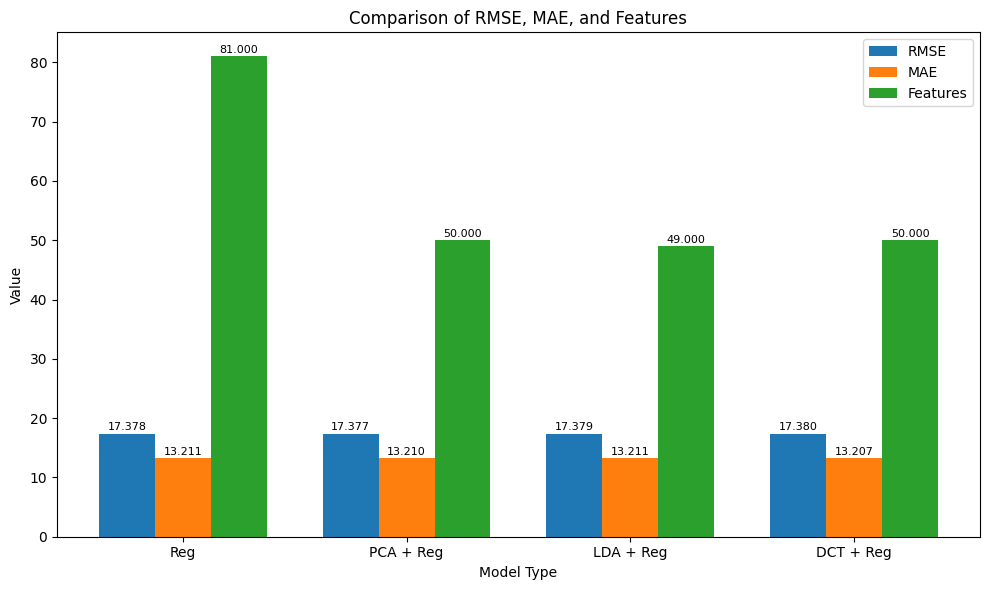

In [12]:
# Define data
data = {
    'Model': ['Reg', 'PCA + Reg', 'LDA + Reg', 'DCT + Reg'],
    'RMSE': RMSE_res[2],
    'MAE': MAE_res[2],
    'Features': [sublist[2][1] if len(sublist) >= 3 else sublist[0][1] for sublist in Features_res],
    'Train_Time': Train_Time_res[2],
    'R_Square': R_Square_res[2]
}

# Create DataFrame
df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.25
x = range(len(df))

# Plot bars
rmse_bars = ax.bar([i - bar_width for i in x], df['RMSE'], width=bar_width, label='RMSE', color='#1f77b4')
mae_bars = ax.bar(x, df['MAE'], width=bar_width, label='MAE', color='#ff7f0e')
feat_bars = ax.bar([i + bar_width for i in x], df['Features'], width=bar_width, label='Features', color='#2ca02c')

# Add text labels above bars
for bars in [rmse_bars, mae_bars, feat_bars]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height + 0.2, f'{height:.3f}',
                ha='center', va='bottom', fontsize=8, rotation=0)

ax.set_xlabel('Model Type')
ax.set_ylabel('Value')
ax.set_title('Comparison of RMSE, MAE, and Features')
ax.set_xticks(list(x))
ax.set_xticklabels(df['Model'])
ax.legend()
plt.tight_layout()
plt.show()

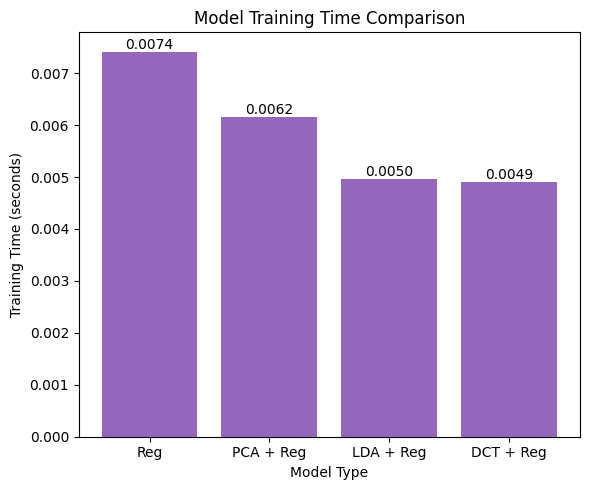

In [13]:
plt.figure(figsize=(6, 5))
plt.bar(df['Model'], df['Train_Time'], color='#9467bd')
plt.title('Model Training Time Comparison')
plt.xlabel('Model Type')
plt.ylabel('Training Time (seconds)')
for i, v in enumerate(df['Train_Time']):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

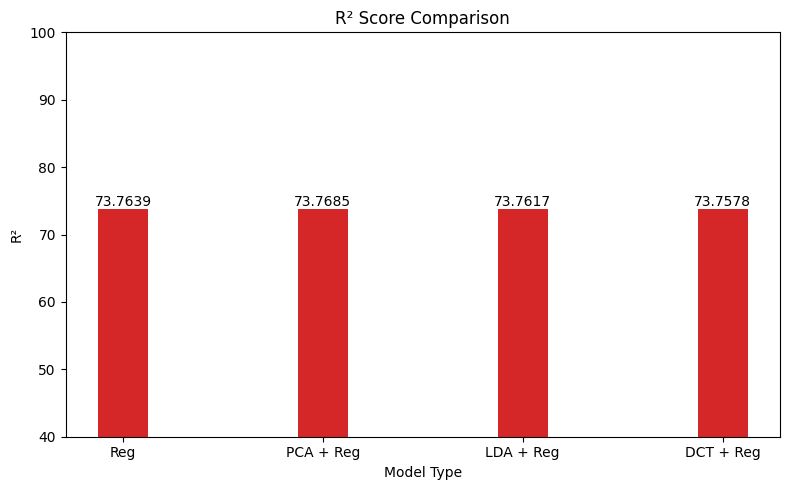

In [14]:
plt.figure(figsize=(8, 5))
plt.bar(df['Model'], df['R_Square'], width=bar_width, color='#d62728')
plt.title('R² Score Comparison')
plt.xlabel('Model Type')
plt.ylabel('R²')
bar_width = 0.2
for i, v in enumerate(df['R_Square']):
    plt.text(i, v, f'{v:.4f}', ha='center', va='bottom')

plt.ylim(40, 100)
# plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [15]:
# Draw Graph

def draw_graph (res_data, graph_title):
    plt.figure(figsize=(10, 5))
    bar_width = 0.15
    group_gap = 0.5
    intra_gap = 0.1

    colors = ["#4CAF50", "#2196F3", "#FFC107", "#9C27B0", "#FF5722"]

    x = 0
    x_pos = []
    bar_colors = []
    values = []
    tick_labels = []

    group_centers = []

    # Populate bar positions, values, and colors, while tracking group center positions
    max_val = 0;
    for i, data in enumerate(res_data):
        group_start_x = x
        for j, val in enumerate(data):
            if val > max_val:
                max_val = val
            x_pos.append(x)
            bar_colors.append(colors[(j+1) % len(colors)] if i > 0 else colors[0])
            values.append(val)
            tick_labels.append(features[j+1] if i > 0 else features[0])
            x += bar_width + intra_gap
        group_end_x = x - bar_width
        # Calculate center for group label positioning
        group_centers.append((group_start_x + group_end_x)/2)
        x += group_gap

    bars = plt.bar(x_pos, values, width=bar_width, color=bar_colors)
    plt.xticks(x_pos, tick_labels, fontsize=10)

    plt.ylabel(f"{graph_title}", fontsize=12)
    plt.title(f"{graph_title} vs Features", fontsize=13)
    plt.subplots_adjust(bottom=0.28)  # Extra bottom margin for labels

    # Add legend for features
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(len(features))]
    plt.legend(handles, features, title="Features", bbox_to_anchor=(1.05, 1), loc="upper left")

    # Add bold group labels below each cluster of bars
    y_min = plt.ylim(0,max_val + max_val/2)[0]
    # y_offset = -0.04  # Move group labels further down if cut off
    # for center, label in zip(group_centers, groups):
    #     plt.text(center, y_min + y_offset, label, ha='center', va='top', fontsize=11, fontweight='bold')

    # Add values on top of each bar (dynamically placed)
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,  # X position: center of bar
            height + height*0.02,            # Y position: slightly above bar
            f"{height:.2f}",                 # Text: bar value
            ha='center',
            va='bottom',
            fontsize=9
        )

    # Dynamically add group labels below ticks
    y_min, y_max = plt.ylim()
    y_offset = (y_max - y_min) * -0.12  # dynamic offset below feature labels

    for center, label in zip(group_centers, groups):
        plt.text(
            center,
            y_min + y_offset,
            label,
            ha='center',
            va='top',
            fontsize=11,
            fontweight='bold'
        )

    # plt.tight_layout()
    plt.show()

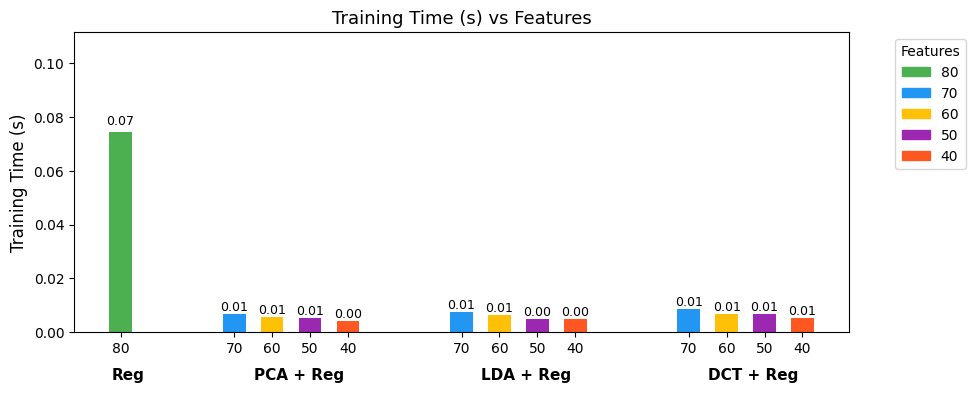

In [16]:
# Training Time vs Features

res_data = Train_Time_res

draw_graph(res_data, "Training Time (s)")

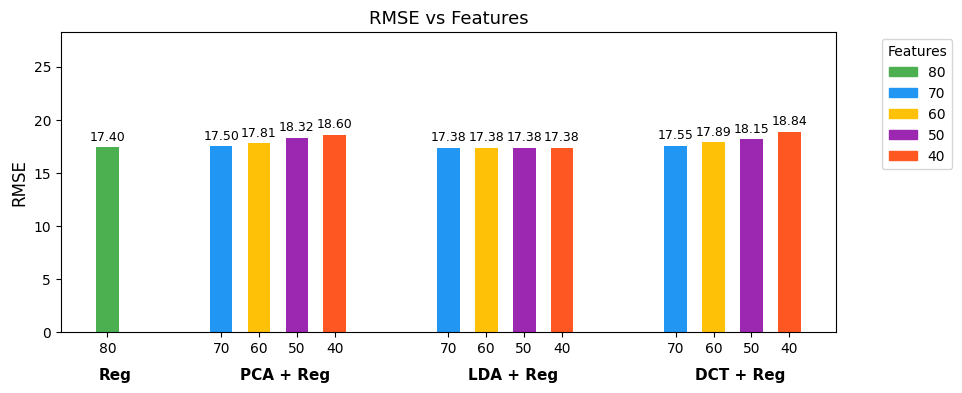

In [17]:
# RMSE vs Features

res_data = RMSE_res

draw_graph(res_data, "RMSE")

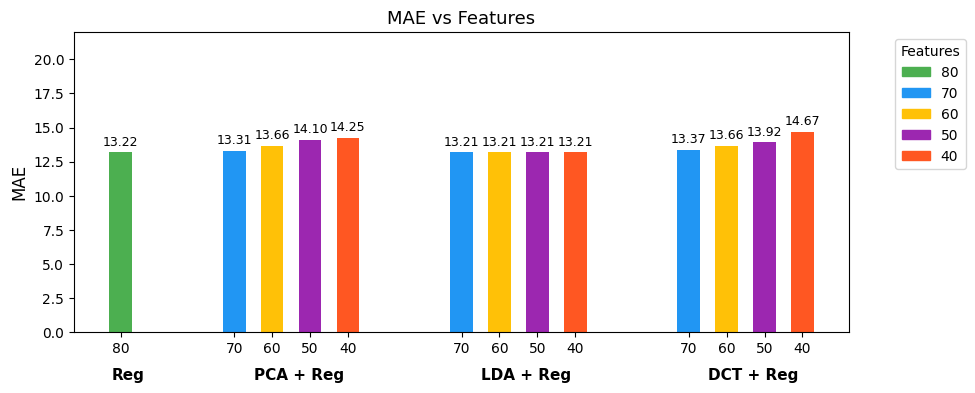

In [18]:
# MAE vs Features

res_data = MAE_res

draw_graph(res_data, "MAE")

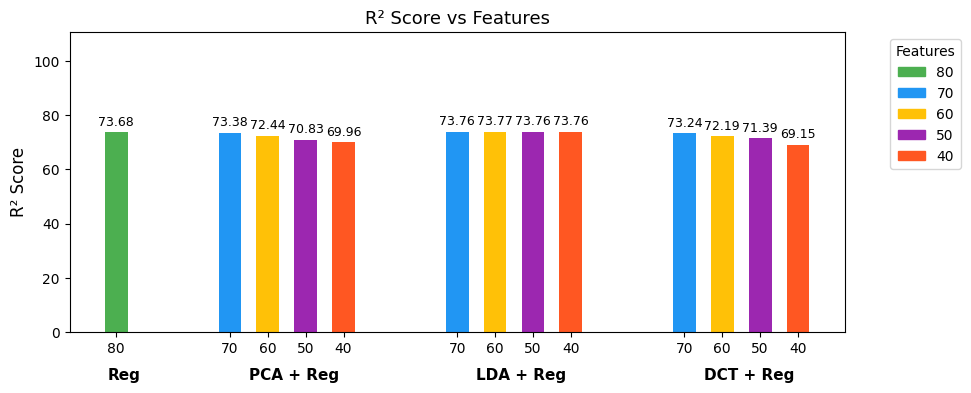

In [19]:
# R² Score vs Features

res_data = R_Square_res

draw_graph(res_data, "R² Score")

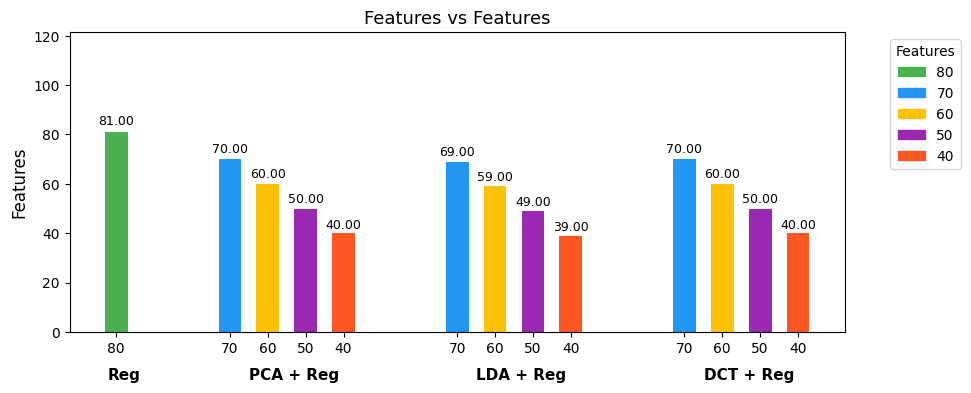

In [20]:
# Features vs Features

res_data = [[t[1] for t in sublist] for sublist in Features_res]

draw_graph(res_data, "Features")

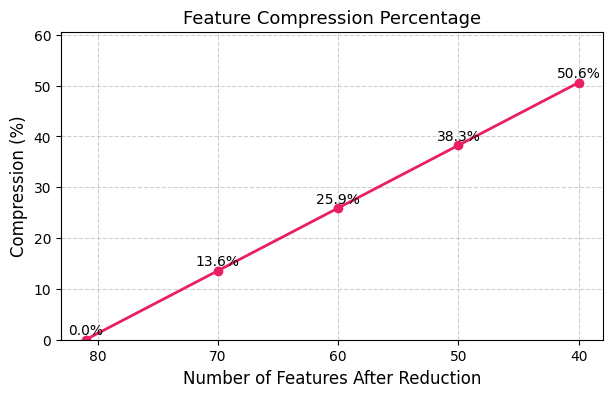

In [21]:
# Original and reduced features
features = [81] + res_data[3]

# Compute compression percentage = how much reduction happened
compression_percent = [(1 - f / 81) * 100 for f in features]

plt.figure(figsize=(7, 4))
plt.plot(features, compression_percent, marker='o', linestyle='-', color='#E91E63', linewidth=2)

# Annotate each point with its compression percentage
for x, y in zip(features, compression_percent):
    plt.text(x, y + 1, f"{y:.1f}%", ha='center', fontsize=10)

plt.title("Feature Compression Percentage", fontsize=13)
plt.xlabel("Number of Features After Reduction", fontsize=12)
plt.ylabel("Compression (%)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(0, max(compression_percent) + 10)

# Reverse X-axis so it shows decreasing features but increasing compression
plt.gca().invert_xaxis()

plt.show()
